In [10]:
import pandas as pd
import os
from pysam import VariantFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce

plt.style.use('aa_paper')
%matplotlib inline

# Reformat VCFs in parallel

Using a script called `get_gens_df.py` in `AlleleAnalyzer/generate_gens_dfs/get_gens_df.py`, we reformat the 1000 Genomes VCFs in order to more easily annotate variants for whether they are near or in PAM sites. This is necessary because in ordinary VCF files, variants can have multiple alleles listed on one line, and these need to be split up for annotation based on each individual allele.

For the 1000 Genomes analysis, we parallelized this process by splitting the genome into 10kb windows. (Will this make too many files? Maybe 500kb would be more feasible, then redo any that don't work, similar to ExAc approach. This approach is used because 1000 Genomes data is whole-genome rather than exome, like ExAc.

Make 10 kb windows of the genome using `bedtools makewindows`.

## hg19

`bedtools makewindows -g hg19.sizes -w 10000 > hg19.10kbwindows.bed`

313,762 regions for hg19.

### Add unique regions IDs

In [78]:
# hg19_regions = pd.read_csv('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/dat/hg19.10kbwindows.bed',
#                           sep='\t', header=None, names=['chrom','start','stop'])
# hg19_regions['region_id'] = 'region_' + hg19_regions.index.astype(str)

# # hg19_regions.to_csv('dat/1kgp_hg19_regions.bed', sep='\t', index=False, header=False)

In [2]:
hg19_regions = pd.read_csv('dat/1kgp_hg19_regions.bed', sep='\t', header=None,
                          names=['chrom','start','stop','region_id'])

## Check whether all regions were appropriately reformatted

In [4]:
hg19_regions['gens_fname'] = '/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_formatted_variants/' + hg19_regions['region_id'] + '.h5'

hg19_regions['gens_complete'] = hg19_regions['gens_fname'].map(os.path.isfile)

In [5]:
hg19_regions.query('~gens_complete').head()

,chrom,start,stop,region_id,gens_fname,gens_complete


In [4]:
len(hg19_regions.query('~gens_complete'))

0

In [5]:
hg19_regions.to_csv('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/region_annots.tsv',
                   sep='\t', index=False)

## Check whether annotations were completed for appropriate regions

In [3]:
hg19_regions['region_id'] = hg19_regions['region_id'].str.replace('_','')

hg19_regions['annots_fname'] = '/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_annotated_variants/' + \
hg19_regions['region_id'] + '.h5'

In [8]:
hg19_regions['annots_fname'].tolist()[0]

'/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_annotated_variants/region0.h5'

In [9]:
hg19_regions['annots_file_exists'] = hg19_regions['annots_fname'].map(os.path.isfile)

In [10]:
len(hg19_regions.query('~annots_file_exists'))

51201

In [6]:
hg19_regions.to_csv('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/region_annots.tsv',
                   sep='\t', index=False)

In [2]:
# generate supplementary table 3, first 100 annotated variants on chromosome 1

chr1_annots = pd.read_hdf('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_annotated_variants_by_chrom/chr1_annotated.h5',
                         stop=100)

In [4]:
chr1_annots.to_excel('/pollard/home/kathleen/projects/supp_table_3_.xlsx', index=False)

# ExcisionFinder results



`python gene_targ_variation.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv /pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom/ /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/src/hg19_analysis/plotting/`

Targetable genes per person, just change the dir where h5 files are pulled to do 5kb window analysis.

`python targ_genes_per_person.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv /pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom/ targ_genes_per_person`

with 5kb flanking

`python targ_genes_per_person.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv /pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom_5kb_window targ_genes_per_person_5kb`

# Determine mean # putatively targetable autosomal genes per person in 1000 Genomes Cohort

In [2]:
genes = pd.read_csv('/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg19.tsv',
                   sep='\t')
autosomal_genes = genes.query('(chrom != "chrX") and (chrom != "chrY")')
protein_coding_autosomal_genes = set(genes[genes['name'].str.startswith('NM')]['official_gene_symbol'].tolist())

In [3]:
genes.query('official_gene_symbol == "BEST1"')

,official_gene_symbol,name,chrom,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,size
1694,BEST1,NR_134580.1,chr11,61717355,61731935,61731935,61731935,11,"61717355,61719242,61722578,61723189,61724315,6...","61717899,61719430,61722673,61723423,61724470,6...",14580


In [14]:
targ_genes_per_person = np.load('/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/src/hg19_analysis/plotting/targ_genes_per_persongenes_per_person.npy').item()
targ_genes_per_person_5kb = np.load('/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/src/hg19_analysis/plotting/targ_genes_per_person_5kbgenes_per_person.npy').item()

In [11]:
gene_name_dict = {}

genes_eval = 0

for c_dir in os.listdir('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom'):
    genes_in_dir = os.listdir(os.path.join('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom', c_dir))
    for gene in genes_in_dir:
        if gene.endswith('.h5'):
            genes_eval += 1
            
#     print(genes_in_dir[:5])

In [12]:
print(genes_eval)

20861


In [13]:
len(genes)

27090

In [8]:
def translate_gene_name(gene_name):
    """
    HDF5 throws all sort of errors when you have weird punctuation in the gene name, so
    this translates it to a less offensive form.
    """
    repls = ("-", "dash"), (".", "period")
    trans_gene_name = reduce(lambda a, kv: a.replace(*kv), repls, str(gene_name))
    return trans_gene_name

In [17]:
gene_dict = {}
genes_eval = 0

for chrom in list(range(1,23)):
    c_dir = os.path.join('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom',f'chr{chrom}_ef_results/')
    genes_in_dir = os.listdir(os.path.join('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom', c_dir))
    for gene in genes_in_dir:
        if gene.endswith('.h5'):
            genes_eval += 1
            gene_dict[gene[:-3]] = translate_gene_name(gene[:-3])

In [19]:
gene_dict = {}
genes_eval = 0

for chrom in list(range(1,23)):
    c_dir = os.path.join('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom_5kb_window/',f'chr{chrom}_ef_results/')
    genes_in_dir = os.listdir(os.path.join('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg19_analysis/1kgp_excisionfinder_results/results_by_chrom_5kb_window/', c_dir))
    for gene in genes_in_dir:
        if gene.endswith('.h5'):
            genes_eval += 1
            gene_dict[gene[:-3]] = translate_gene_name(gene[:-3])

In [20]:
gene_dict_df = pd.DataFrame.from_dict(gene_dict, orient='index')

gene_dict_df['gene'] = gene_dict_df.index

gene_dict_df.columns = ['translated_gene','gene']

gene_dict_df.head()

gene_dict_df.to_csv('/pollard/data/projects/AlleleAnalyzer_data/AlleleAnalyzer_supporting_data/1000_genomes_analysis/hg19_analysis/excisionFinder_results/5kb_window/gene_dict.tsv',
                   sep='\t', index=False)

## Gene only (autosomal)

In [7]:
ppl = []
num_targ_genes = []
cas = []

for key in targ_genes_per_person:
    ppl.append(key)
    num_targ_genes.append(len(protein_coding_autosomal_genes.intersection(set(targ_genes_per_person[key]))))
    
targ_genes_per_person_df = pd.DataFrame({'ppl':ppl, 'num_targ_genes':num_targ_genes})

targ_genes_per_person_df['perc_targ_genes'] = targ_genes_per_person_df['num_targ_genes'].divide(len(protein_coding_autosomal_genes)) * 100.0

targ_genes_per_person_df['perc_targ_genes'].mean()

64.01185088503932

## Gene + 5 kb

In [7]:
ppl = []
num_targ_genes = []
cas = []

for key in targ_genes_per_person_5kb:
    ppl.append(key)
    num_targ_genes.append(len(protein_coding_autosomal_genes.intersection(set(targ_genes_per_person_5kb[key]))))
    
targ_genes_per_person_df = pd.DataFrame({'ppl':ppl, 'num_targ_genes':num_targ_genes})

targ_genes_per_person_df['perc_targ_genes'] = targ_genes_per_person_df['num_targ_genes'].divide(len(protein_coding_autosomal_genes)) * 100.0

targ_genes_per_person_df['perc_targ_genes'].mean()

75.38688832921208

# people targetable 

In this faceted density plot, height of the colored portion indicates the proportion of genes where the specified percentage of the 1000 genomes cohort is putatively targetable.

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


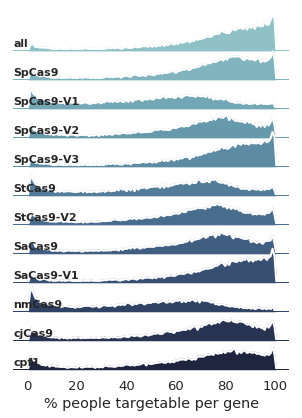

In [29]:
# inspired and helped by this page: https://seaborn.pydata.org/examples/kde_joyplot.html
plot_df = pd.read_csv('/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/src/hg19_analysis/plotting/targ_per_gene_and_cas.tsv',
                                sep='\t')

cas_dict = np.load('/pollard/data/projects/AlleleAnalyzer_data/cas_abbrev_dict.npy').item()
cas_dict['StCas9'] = 'StCas9'
cas_dict['all'] = 'all'

plot_df['% people targetable per gene'] = plot_df['% people targetable']*100.0

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.2)
cas_list = plot_df.Cas.drop_duplicates().tolist()
pal = sns.cubehelix_palette(len(cas_list), rot=-.25, light=.7)

g = sns.FacetGrid(plot_df, row='Cas', hue='Cas', aspect=10, size=.5, palette=pal)
g.map(sns.kdeplot, '% people targetable per gene', shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, '% people targetable per gene', color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, cas_dict[label], fontweight="bold",  
            ha="left", va="center", fontsize=11,transform=ax.transAxes)
    
g.map(label, '% people targetable per gene')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# g.savefig('people_targetable_per_gene_per_cas.pdf', dpi=300, bbox_inches='tight')